In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Phần 0: import thư viện & thiết lập
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid", palette="muted")

ROOT_DIR = "./emcuube"  # điều chỉnh đường dẫn

# 1. Load dữ liệu
train_log = pd.read_csv(os.path.join(ROOT_DIR, "train_log.csv"))
test_log  = pd.read_csv(os.path.join(ROOT_DIR, "test_log.csv"))

lightcurve_files = sorted(glob.glob(os.path.join(ROOT_DIR, "split_*", "*.csv")))
df_list = []
for f in lightcurve_files:
    df_list.append(pd.read_csv(f))
lightcurves = pd.concat(df_list, ignore_index=True)

print("lightcurves:", lightcurves.shape)
print("train_log:", train_log.shape)
print("test_log:", test_log.shape)

lightcurves.head(), train_log.head()


lightcurves: (1624509, 5)
train_log: (3043, 8)
test_log: (7135, 7)


(         object_id  Time (MJD)      Flux  Flux_err Filter
 0  Elrim_sador_hun  61120.3730 -0.867298  1.436325      z
 1  Elrim_sador_hun  62428.9395 -0.412872  0.972737      y
 2  Elrim_sador_hun  62431.2074  0.807585  0.421561      i
 3  Elrim_sador_hun  62431.2074  0.564190  0.702448      z
 4  Elrim_sador_hun  62444.8147  0.495302  0.135575      r,
                   object_id       Z  Z_err    EBV SpecType  \
 0  Dornhoth_fervain_onodrim  3.0490    NaN  0.110      AGN   
 1       Dornhoth_galadh_ylf  0.4324    NaN  0.058    SN II   
 2      Elrim_melethril_thul  0.4673    NaN  0.577      AGN   
 3        Ithil_tobas_rodwen  0.6946    NaN  0.012      AGN   
 4       Mirion_adar_Druadan  0.4161    NaN  0.058      AGN   
 
                                English Translation     split  target  
 0  Trawn Folk (Dwarfs) + northern + Ents (people)   split_01       0  
 1    Trawn Folk (Dwarfs) + tree + drinking vessel   split_01       0  
 2                  Elves +  lover (fem.)  + brea

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624509 entries, 0 to 1624508
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   object_id   1624509 non-null  object 
 1   Time (MJD)  1624509 non-null  float64
 2   Flux        1621596 non-null  float64
 3   Flux_err    1624509 non-null  float64
 4   Filter      1624509 non-null  object 
dtypes: float64(3), object(2)
memory usage: 62.0+ MB
None
object_id        0
Time (MJD)       0
Flux          2913
Flux_err         0
Filter           0
dtype: int64
         Time (MJD)          Flux      Flux_err
count  1.624509e+06  1.621596e+06  1.624509e+06
mean   6.291452e+04  5.436850e-01  4.565760e-01
std    9.003290e+02  2.250092e+00  4.351176e-01
min    6.097954e+04 -4.252119e+01  2.717943e-02
25%    6.220599e+04 -1.859882e-01  1.850018e-01
50%    6.296362e+04  1.680723e-01  3.105148e-01
75%    6.359646e+04  8.829058e-01  5.320399e-01
max    6.463275e+04  7.667206e+02  1.

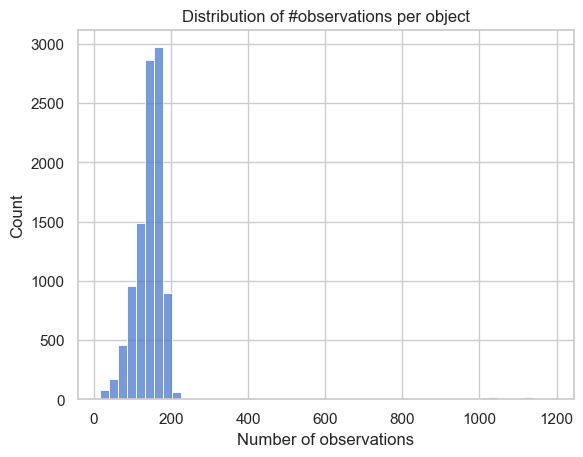

In [3]:
# info, nulls, types
print(lightcurves.info())
print(lightcurves.isnull().sum())
print(lightcurves.describe())

# Số lượng object, số quan sát trung bình / median / distribution
obs_counts = lightcurves.groupby('object_id').size()
print("Object count:", obs_counts.shape[0])
print(obs_counts.describe())
sns.histplot(obs_counts, bins=50)
plt.title("Distribution of #observations per object")
plt.xlabel("Number of observations")
plt.show()


Filter
r    372949
i    371784
z    331223
y    239217
g    167884
u    141452
Name: count, dtype: int64


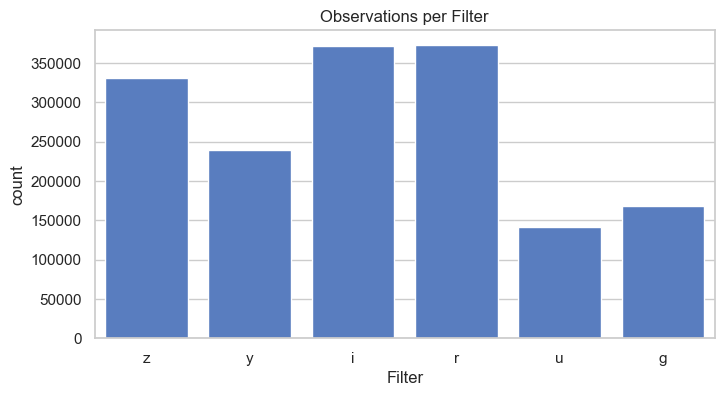

In [4]:
print(lightcurves['Filter'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(data=lightcurves, x='Filter')
plt.title("Observations per Filter")
plt.show()


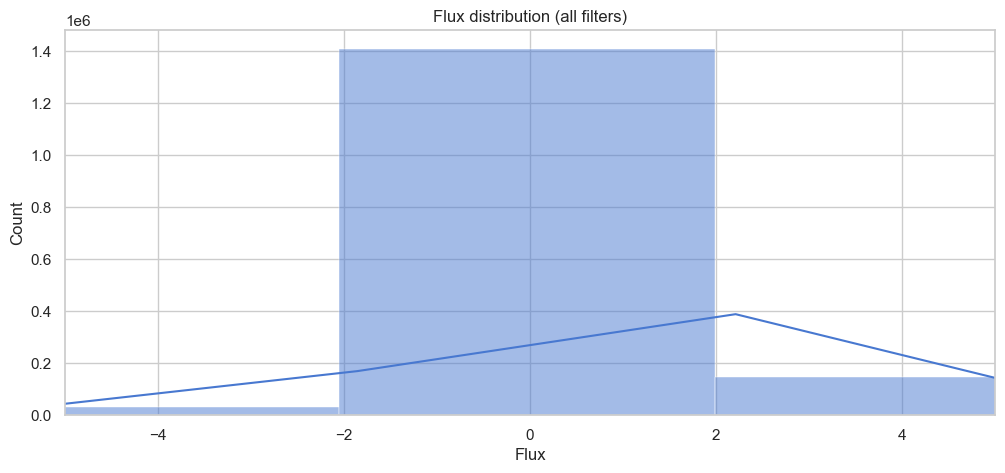

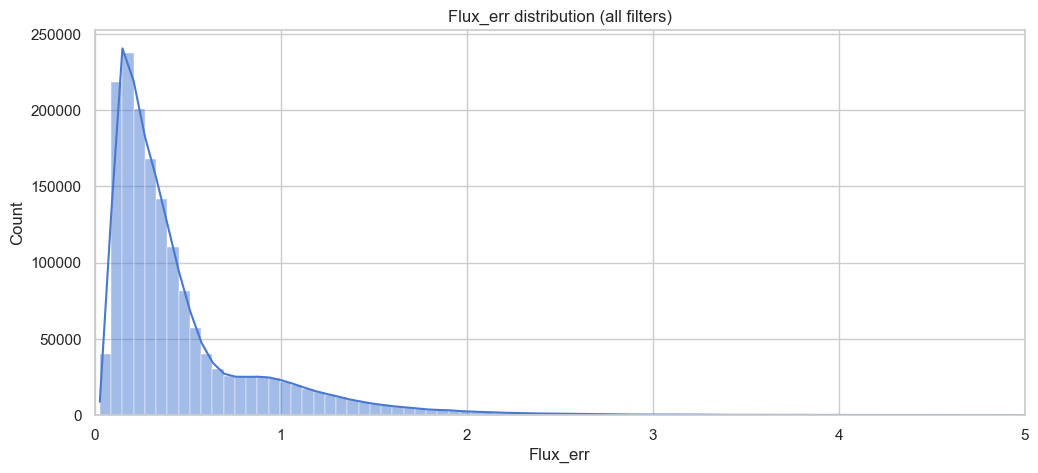

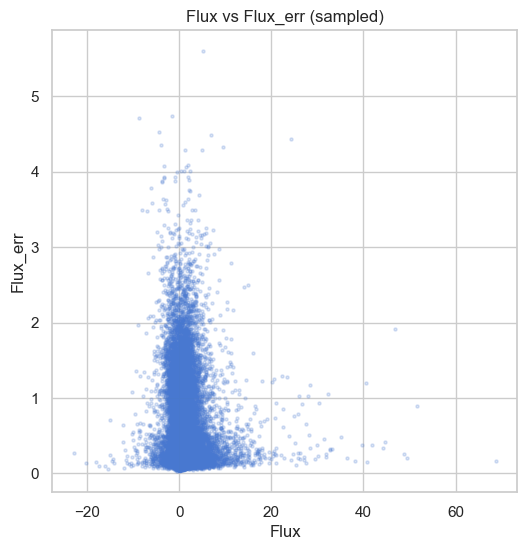

In [5]:
plt.figure(figsize=(12,5))
sns.histplot(lightcurves['Flux'], bins=200, kde=True)
plt.title("Flux distribution (all filters)")
plt.xlim(-5,5)
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(lightcurves['Flux_err'], bins=200, kde=True)
plt.title("Flux_err distribution (all filters)")
plt.xlim(0, 5)
plt.show()

# Flux vs Flux_err relationship (sample để avoid quá nặng)
df_sample = lightcurves.sample(50000, random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(df_sample['Flux'], df_sample['Flux_err'], alpha=0.2, s=5)
plt.xlabel("Flux")
plt.ylabel("Flux_err")
plt.title("Flux vs Flux_err (sampled)")
plt.show()


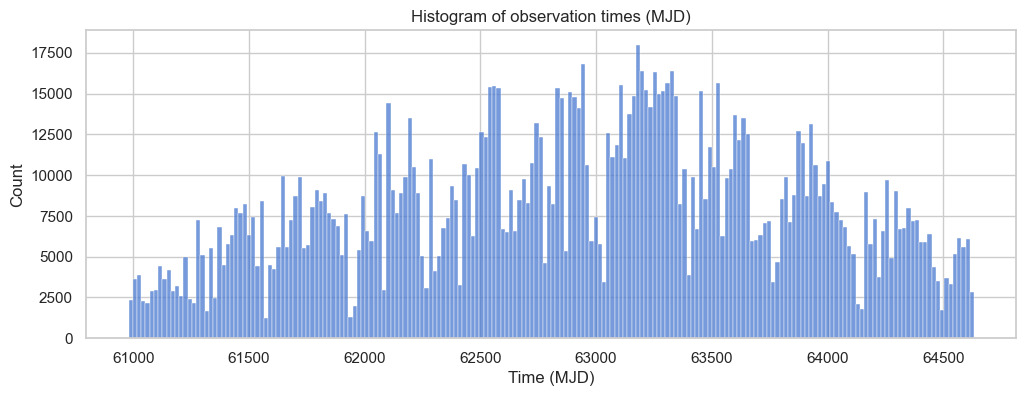

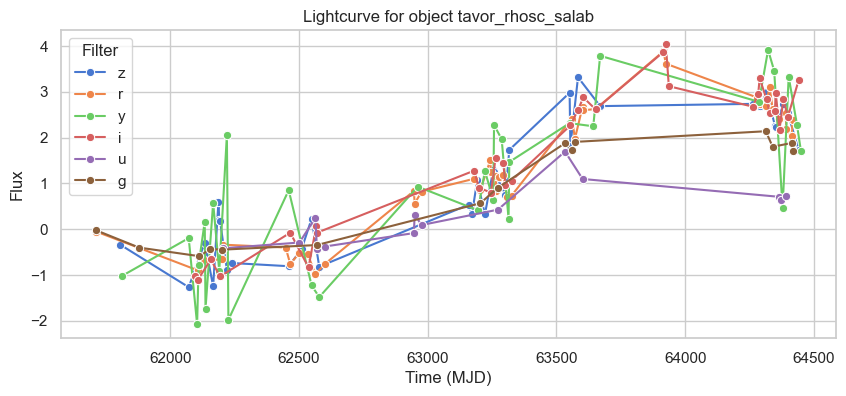

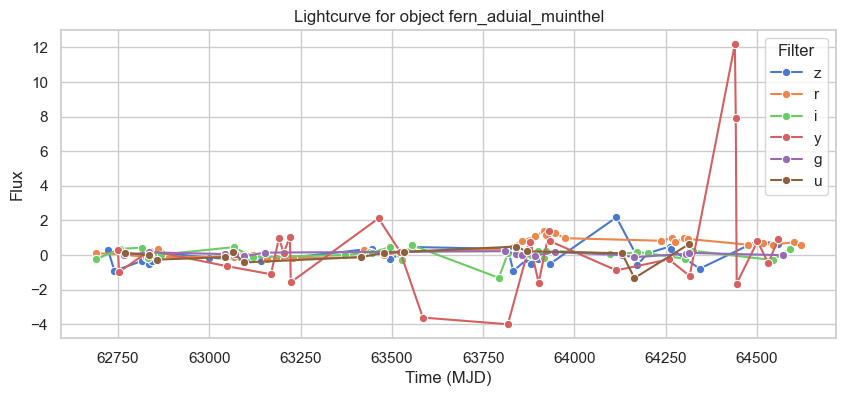

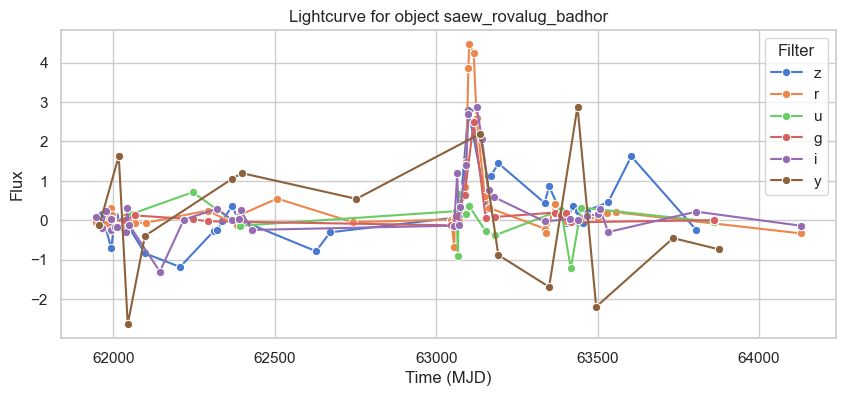

In [6]:
plt.figure(figsize=(12,4))
sns.histplot(lightcurves['Time (MJD)'], bins=200)
plt.title("Histogram of observation times (MJD)")
plt.show()

# Quan sát một số lightcurve ví dụ
for oid in np.random.choice(lightcurves['object_id'].unique(), 3, replace=False):
    df = lightcurves[lightcurves['object_id']==oid]
    plt.figure(figsize=(10,4))
    sns.lineplot(data=df, x='Time (MJD)', y='Flux', hue='Filter', marker='o')
    plt.title(f"Lightcurve for object {oid}")
    plt.show()


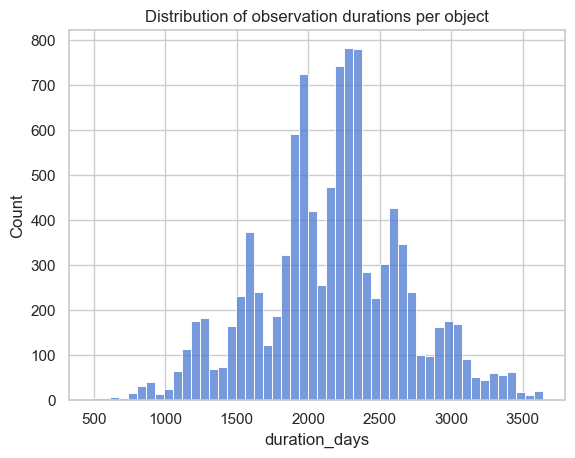

In [7]:
# Ví dụ tính một số feature đơn giản per object:
group = lightcurves.groupby('object_id')
obj_stats = pd.DataFrame({
    'n_obs': group.size(),
    'min_flux': group['Flux'].min(),
    'max_flux': group['Flux'].max(),
    'mean_flux': group['Flux'].mean(),
    'std_flux': group['Flux'].std(),
    'min_mjd': group['Time (MJD)'].min(),
    'max_mjd': group['Time (MJD)'].max(),
})
obj_stats['duration_days'] = obj_stats['max_mjd'] - obj_stats['min_mjd']

obj_stats.describe().T
sns.histplot(obj_stats['duration_days'], bins=50)
plt.title("Distribution of observation durations per object")
plt.show()


In [10]:
# Phan 1b: missing, duplicate, coverage
print('Lightcurves nulls:', lightcurves.isnull().sum())

dup_rows = lightcurves.duplicated(subset=['object_id', 'Time (MJD)', 'Filter']).sum()
print('Duplicate rows (object_id, Time, Filter):', dup_rows)

lightcurve_objects = set(lightcurves['object_id'].unique())
train_objects = set(train_log['object_id'])
test_objects = set(test_log['object_id'])

print('Train objects missing in lightcurves:', len(train_objects - lightcurve_objects))
print('Test objects missing in lightcurves:', len(test_objects - lightcurve_objects))
print('Lightcurve objects missing in train/test log:', len(lightcurve_objects - train_objects - test_objects))

print('Train split counts:', train_log['split'].value_counts().sort_index())
print('Test split counts:', test_log['split'].value_counts().sort_index())


Lightcurves nulls: object_id        0
Time (MJD)       0
Flux          2913
Flux_err         0
Filter           0
dtype: int64
Duplicate rows (object_id, Time, Filter): 0
Train objects missing in lightcurves: 0
Test objects missing in lightcurves: 0
Lightcurve objects missing in train/test log: 0
Train split counts: split
split_01    155
split_02    170
split_03    138
split_04    145
split_05    165
split_06    155
split_07    165
split_08    162
split_09    128
split_10    144
split_11    146
split_12    155
split_13    143
split_14    154
split_15    158
split_16    155
split_17    153
split_18    152
split_19    147
split_20    153
Name: count, dtype: int64
Test split counts: split
split_01    364
split_02    414
split_03    338
split_04    332
split_05    375
split_06    374
split_07    398
split_08    387
split_09    289
split_10    331
split_11    325
split_12    353
split_13    379
split_14    351
split_15    342
split_16    354
split_17    351
split_18    345
split_19    375
s

target
0    2895
1     148
Name: count, dtype: int64
target
0    0.951364
1    0.048636
Name: proportion, dtype: float64


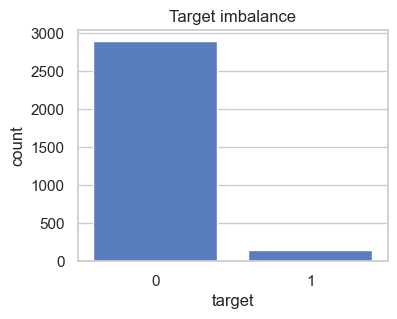

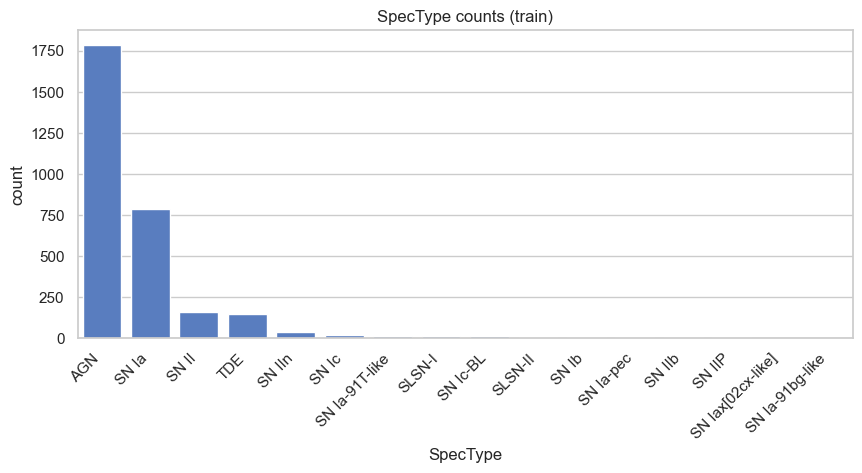

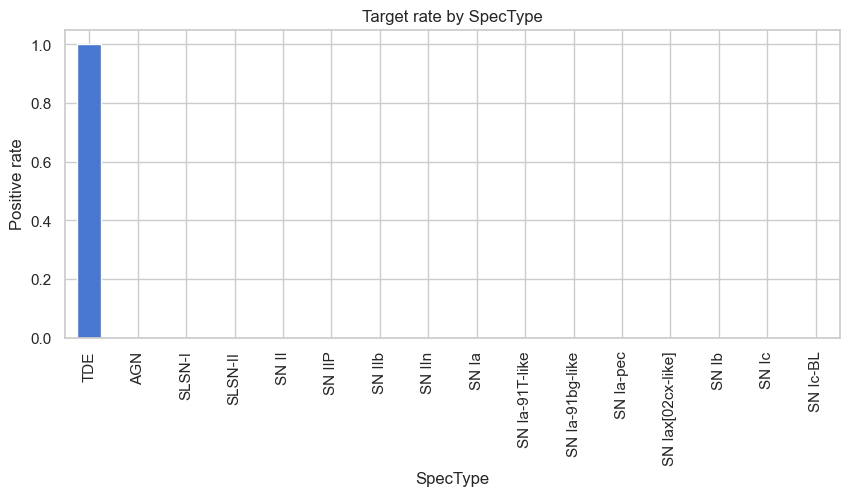

In [11]:
# Phan 2: target imbalance & SpecType
print(train_log['target'].value_counts())
print(train_log['target'].value_counts(normalize=True))

plt.figure(figsize=(4,3))
sns.countplot(data=train_log, x='target')
plt.title('Target imbalance')
plt.show()

spec_counts = train_log['SpecType'].value_counts()
plt.figure(figsize=(10,4))
order = spec_counts.index
sns.countplot(data=train_log, x='SpecType', order=order)
plt.xticks(rotation=45, ha='right')
plt.title('SpecType counts (train)')
plt.show()

spec_target = train_log.groupby('SpecType')['target'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
spec_target.plot(kind='bar')
plt.ylabel('Positive rate')
plt.title('Target rate by SpecType')
plt.show()


Missing rate (train):
object_id              0.0
Z                      0.0
Z_err                  1.0
EBV                    0.0
SpecType               0.0
English Translation    0.0
split                  0.0
target                 0.0
dtype: float64
Missing rate (test):
object_id              0.0
Z                      0.0
Z_err                  0.0
EBV                    0.0
SpecType               1.0
English Translation    0.0
split                  0.0
dtype: float64


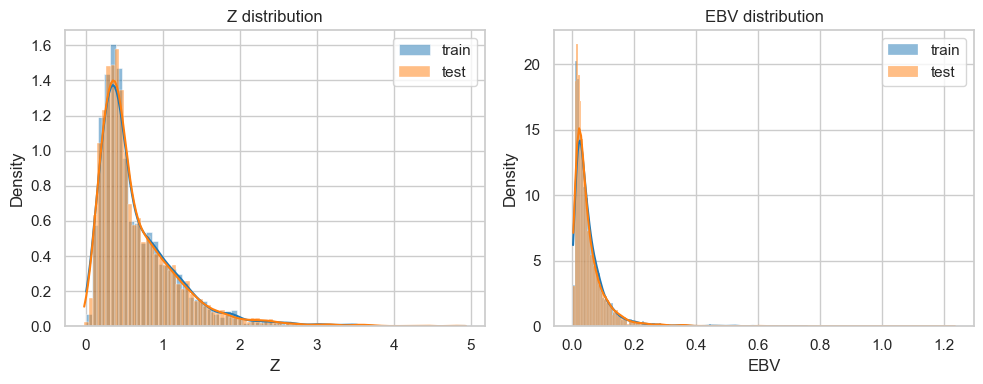

In [12]:
# Phan 3: train vs test distribution (log features)
print('Missing rate (train):')
print(train_log.isnull().mean())
print('Missing rate (test):')
print(test_log.isnull().mean())

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(train_log['Z'], kde=True, stat='density', ax=axes[0], color='tab:blue', label='train')
sns.histplot(test_log['Z'], kde=True, stat='density', ax=axes[0], color='tab:orange', label='test')
axes[0].set_title('Z distribution')
axes[0].legend()

sns.histplot(train_log['EBV'], kde=True, stat='density', ax=axes[1], color='tab:blue', label='train')
sns.histplot(test_log['EBV'], kde=True, stat='density', ax=axes[1], color='tab:orange', label='test')
axes[1].set_title('EBV distribution')
axes[1].legend()
plt.tight_layout()
plt.show()


Filter
g    167884
i    371784
r    372949
u    141452
y    239217
z    331223
Name: count, dtype: int64


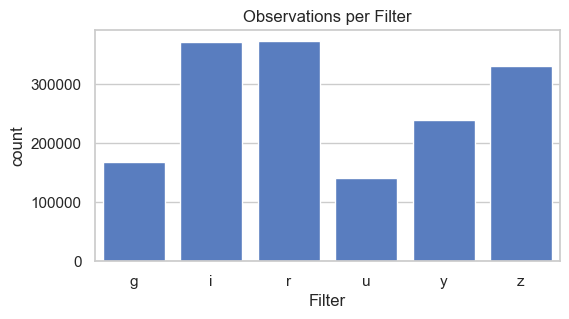

          count       mean        std  min   25%   50%   75%    max
Filter                                                             
g       10178.0  16.494793  20.382329  0.0  11.0  14.0  17.0  212.0
i       10178.0  36.528198  20.763804  3.0  29.0  35.0  40.0  231.0
r       10178.0  36.642661  21.698089  4.0  29.0  35.0  40.0  244.0
u       10178.0  13.897819  17.064466  0.0   9.0  12.0  14.0  162.0
y       10178.0  23.503341  18.019370  0.0  17.0  22.0  26.0  184.0
z       10178.0  32.543034  21.667328  2.0  25.0  31.0  36.0  247.0
Share of objects with each filter: Filter
i    1.000000
r    1.000000
z    1.000000
g    0.999607
y    0.994301
u    0.993712
dtype: float64


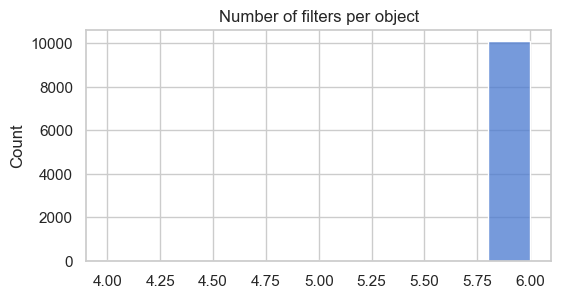

In [13]:
# Phan 4: filter usage & per-object coverage
print(lightcurves['Filter'].value_counts().sort_index())

plt.figure(figsize=(6,3))
sns.countplot(data=lightcurves, x='Filter', order=sorted(lightcurves['Filter'].unique()))
plt.title('Observations per Filter')
plt.show()

per_obj_filter = lightcurves.groupby(['object_id', 'Filter']).size().unstack(fill_value=0)
print(per_obj_filter.describe().T)

has_filter = (per_obj_filter > 0).mean().sort_values(ascending=False)
print('Share of objects with each filter:', has_filter)

n_filters = (per_obj_filter > 0).sum(axis=1)
plt.figure(figsize=(6,3))
sns.histplot(n_filters, bins=10)
plt.title('Number of filters per object')
plt.show()


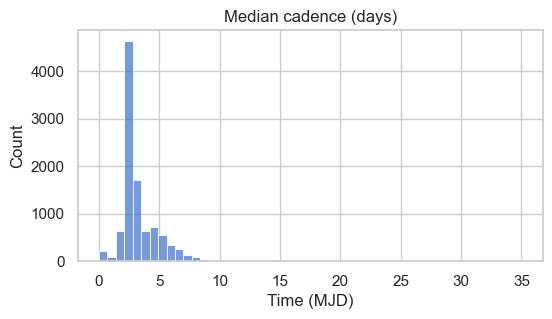

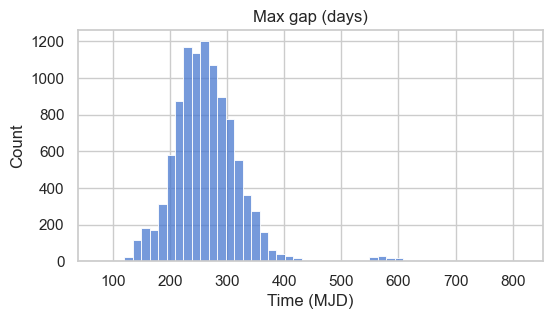

In [14]:
# Phan 5: time cadence & gaps
import numpy as np

def median_dt(x):
    x = np.sort(x)
    if len(x) < 2:
        return np.nan
    return np.median(np.diff(x))

def max_gap(x):
    x = np.sort(x)
    if len(x) < 2:
        return np.nan
    return np.max(np.diff(x))

cadence = lightcurves.groupby('object_id')['Time (MJD)'].apply(median_dt)
max_gap_series = lightcurves.groupby('object_id')['Time (MJD)'].apply(max_gap)

plt.figure(figsize=(6,3))
sns.histplot(cadence.dropna(), bins=50)
plt.title('Median cadence (days)')
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(max_gap_series.dropna(), bins=50)
plt.title('Max gap (days)')
plt.show()


In [15]:
# Phan 6: simple aggregated features & correlation with target
lc = lightcurves.copy()
with np.errstate(divide='ignore', invalid='ignore'):
    lc['snr'] = lc['Flux'] / lc['Flux_err']

group = lc.groupby('object_id')
obj_feat = pd.DataFrame({
    'n_obs': group.size(),
    'n_filters': group['Filter'].nunique(),
    'duration': group['Time (MJD)'].max() - group['Time (MJD)'].min(),
    'flux_mean': group['Flux'].mean(),
    'flux_std': group['Flux'].std(),
    'flux_p10': group['Flux'].quantile(0.1),
    'flux_p90': group['Flux'].quantile(0.9),
    'flux_amp': group['Flux'].max() - group['Flux'].min(),
    'snr_mean': group['snr'].mean(),
    'snr_std': group['snr'].std(),
})
obj_feat['cadence_median'] = cadence
obj_feat['max_gap'] = max_gap_series

train_feat = train_log[['object_id', 'target']].merge(obj_feat, on='object_id', how='left')

corr = train_feat.drop(columns=['object_id']).corr(numeric_only=True)['target'].sort_values(ascending=False)
print(corr)


target            1.000000
flux_p10          0.053477
duration          0.015082
n_obs             0.007367
n_filters         0.006658
snr_mean         -0.014200
flux_mean        -0.015761
flux_p90         -0.016433
max_gap          -0.017649
flux_amp         -0.021563
snr_std          -0.026032
flux_std         -0.028643
cadence_median   -0.031167
Name: target, dtype: float64


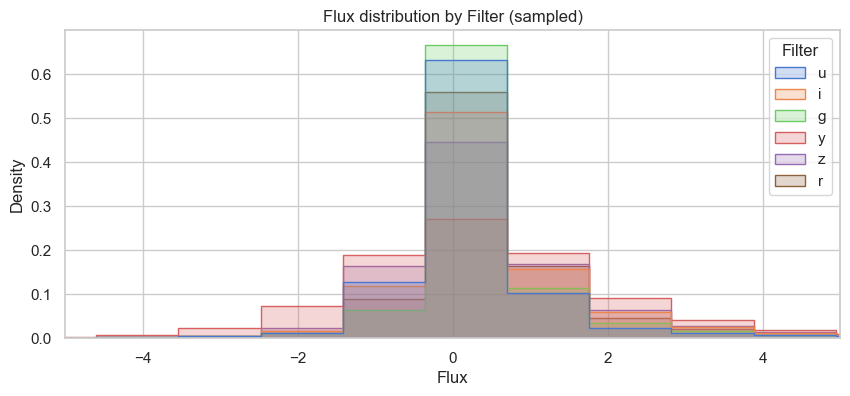

In [16]:
# Phan 7: flux distribution by filter (sample for speed)
plot_sample = lightcurves.sample(min(200000, len(lightcurves)), random_state=42)

plt.figure(figsize=(10,4))
sns.histplot(data=plot_sample, x='Flux', hue='Filter', bins=120, element='step', stat='density', common_norm=False)
plt.title('Flux distribution by Filter (sampled)')
plt.xlim(-5, 5)
plt.show()
